# Model analyze

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import os, json
from sklearn.metrics import confusion_matrix
import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms.functional as FT
import numpy as np
import cv2
from matplotlib import patches
import gdown
import tarfile
import seaborn as sns
import pandas as pd


Load our test image and see how it looks.

In [2]:
url = 'https://drive.google.com/uc?id=1GsC6vtBm47kNUPrCU-8_hXU1Pi0BraE9'
output = '/content/train.tar'
gdown.download(url, output, quiet=False)
tf = tarfile.open(output)
tf.extractall('/content/')

url = 'https://drive.google.com/uc?id=1JVCAqZOhKCs3_5KrlZakB-ZJZTcyZSS3'
output = '/content/test.tar'
gdown.download(url, output, quiet=False)
tf = tarfile.open(output)
tf.extractall('/content/')

Downloading...
From: https://drive.google.com/uc?id=1GsC6vtBm47kNUPrCU-8_hXU1Pi0BraE9
To: /content/train.tar
295MB [00:06, 47.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JVCAqZOhKCs3_5KrlZakB-ZJZTcyZSS3
To: /content/test.tar
73.1MB [00:01, 52.9MB/s]


In [3]:
class Darknet53(nn.Module):
    def __init__(self):
        super(Darknet53, self).__init__()
        self.darknet53 = self.darknet_53()
        self.bbox = nn.Sequential(
            nn.Conv2d(1024, 5, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(5),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Sigmoid()
        )

    def darknet_53(self):
        return nn.Sequential(
            convolutional_layer(3, 32, kernel_size=3, padding=1, stride=1),
            convolutional_layer(32, 64, kernel_size=3, padding=1, stride=2),
            nn.Sequential(*[residual_block(in_channels=64, out_channels=32) for _ in range(1)]),  # residual
            convolutional_layer(64, 128, kernel_size=3, padding=1, stride=2),
            nn.Sequential(*[residual_block(in_channels=128, out_channels=64) for _ in range(2)]),  # residual
            convolutional_layer(128, 256, kernel_size=3, padding=1, stride=2),
            nn.Sequential(*[residual_block(in_channels=256, out_channels=128) for _ in range(8)]),  # residual
            convolutional_layer(256, 512, kernel_size=3, padding=1, stride=2),
            nn.Sequential(*[residual_block(in_channels=512, out_channels=256) for _ in range(8)]),  # residual
            convolutional_layer(512, 1024, kernel_size=3, padding=1, stride=2),
            nn.Sequential(*[residual_block(in_channels=1024, out_channels=512) for _ in range(4)]),  # residual
        )

    def forward(self, image: torch.Tensor):
        features = self.darknet53(image)  # [batch size, 1024, 10, 10]
        out = self.bbox(features).flatten(start_dim=1)
        classifier = out[:, 0]
        bbox = out[:, 1:]
        return classifier, bbox


def convolutional_layer(in_channels, out_channels, kernel_size=3, padding=1, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True)
    )


class residual_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(residual_block, self).__init__()
        self.conv = nn.Sequential(
            convolutional_layer(in_channels, out_channels, kernel_size=1, padding=0, stride=1),
            convolutional_layer(out_channels, in_channels, kernel_size=3, padding=1, stride=1)
        )

    def forward(self, x):
        return x + self.conv(x)

In [5]:
gdrive_file_id = '17SXNA_P7xbuas5zY0zBNZVWRT_Jb44Nk'
url = f'https://drive.google.com/uc?id={gdrive_file_id}'
model_path = os.path.join('model.pth')
gdown.download(url, model_path, quiet=False)

model = torch.load('model.pth')

Downloading...
From: https://drive.google.com/uc?id=17SXNA_P7xbuas5zY0zBNZVWRT_Jb44Nk
To: /content/model.pth
163MB [00:02, 62.8MB/s]


In [7]:
model = torch.load('model.pth')

In [8]:
def parse_images_and_bboxes(image_dir, load_img = False):
    """
    Parse a directory with images.
    :param image_dir: Path to directory with images.
    :return: A list with (filename, image_id, bbox, proper_mask) for every image in the image_dir.
    """
    example_filenames = os.listdir(image_dir)
    data = []
    image_sizes = list()
    for filename in example_filenames:
        image_id, bbox, proper_mask = filename.strip(".jpg").split("__")
        bbox = json.loads(bbox)
        cx, cy, w, h = bbox
        if w <= 0 or h <= 0:
          pass
            # print(image_id)
        proper_mask = True if proper_mask.lower() == "true" else False
        if load_img:
          image = Image.open(os.path.join(image_dir,filename)).convert('RGB')
          data.append((filename, image_id, bbox, proper_mask,
                ([image.width, image.height, image.width, image.height])))
        else:
          data.append((filename, image_id, bbox, proper_mask))
    return data

In [9]:
image_dir = "test"
data = parse_images_and_bboxes(image_dir)

## Plotting the images and their prediction

In [10]:
def calc_iou(bbox_a, bbox_b):
    """
    Calculate intersection over union (IoU) between two bounding boxes with a (x, y, w, h) format.
    :param bbox_a: Bounding box A. 4-tuple/list.
    :param bbox_b: Bounding box B. 4-tuple/list.
    :return: Intersection over union (IoU) between bbox_a and bbox_b, between 0 and 1.
    """
    x1, y1, w1, h1 = bbox_a
    x2, y2, w2, h2 = bbox_b
    w_intersection = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_intersection = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_intersection <= 0.0 or h_intersection <= 0.0:  # No overlap
        return 0.0
    intersection = w_intersection * h_intersection
    union = w1 * h1 + w2 * h2 - intersection  # Union = Total Area - Intersection
    return intersection / union

In [11]:
def plot_image(filename, predicted_box, prediction):
    image_id, bbox, proper_mask = filename.strip(".jpg").split("__")
    bbox = json.loads(bbox)
    proper_mask = True if proper_mask.lower() == "true" else False
    # Load image
    im = cv2.imread(os.path.join('test', filename))
    # BGR to RGB
    im = im[:, :, ::-1]
    # Ground truth bbox
    x1, y1, w1, h1 = bbox
    # Predicted bbox
    x2, y2, w2, h2 = predicted_box
    # Calculate IoU
    iou = calc_iou(bbox, (x2, y2, w2, h2))
    # Plot image and bboxes
    fig, ax = plt.subplots()
    ax.imshow(im)
    rect = patches.Rectangle((x1, y1), w1, h1,
                             linewidth=2, edgecolor='g', facecolor='none', label='ground-truth')
    ax.add_patch(rect)
    rect = patches.Rectangle((x2, y2), w2, h2,
                             linewidth=2, edgecolor='b', facecolor='none', label='predicted')
    ax.add_patch(rect)
    prediction = True if prediction == 1 else False
    fig.suptitle(f"proper_mask={proper_mask}, predicted={prediction}, IoU={iou:.2f}")
    ax.axis('off')
    fig.legend(loc=(0.6,0))
    plt.show()

In [12]:
# resize and take the center part of image to what our model expects
def resize(image, dims):
    """
    Resize image. For the SSD300, resize to (300, 300).
    Since percent/fractional coordinates are calculated for the bounding boxes (w.r.t image dimensions) in this process,
    you may choose to retain them.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: resized image, updated bounding box coordinates (or fractional coordinates, in which case they remain the same)
    """
    # Resize image
    new_image = FT.resize(image, dims)

    # Resize bounding boxes
    old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)

    return new_image

def get_input_tensors(img):
    mean=[0.5244, 0.4904, 0.4781]
    std=[0.2655, 0.2623, 0.2576]
    new_image = resize(img, dims=(240, 240))

    # Convert PIL image to Torch tensor
    new_image = FT.to_tensor(new_image)

    # Normalize by mean and standard deviation of ImageNet data that our base VGG was trained on
    new_image = FT.normalize(new_image, mean=mean, std=std)
    # unsqeeze converts single image to batch of 1
    return new_image.unsqueeze(0)

### Showing examples for wrong labeling

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)
with torch.no_grad():
  for idx,item in enumerate(data):
    if idx <10:
      break
    img = Image.open(os.path.join(image_dir, item[0])).convert('RGB')
    y_bb = torch.FloatTensor(item[2])
    y_class = 1 if item[3] == True else 0
    sizes = torch.FloatTensor([img.width, img.height, img.width, img.height]).unsqueeze(0).to(device)
    img_t = get_input_tensors(img)
    out_class,out_bb = model(img_t.to(device))
    out_bb = torch.mul(out_bb, sizes)
    pred = (out_class > 0.5).int()[0].cpu().detach().numpy()
    iou_val = calc_iou(out_bb[0].cpu().detach().numpy(), y_bb.numpy())
    
    if y_class == pred:
      accuracy = 1
    else:
      accuracy = 0
    if accuracy == 0:
      plot_image(item[0],out_bb[0].cpu().detach().numpy(),pred)


### Showing examples for IoU=0

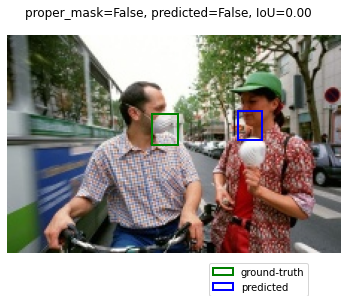

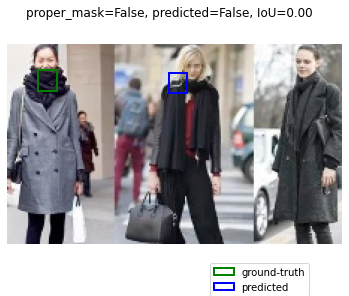

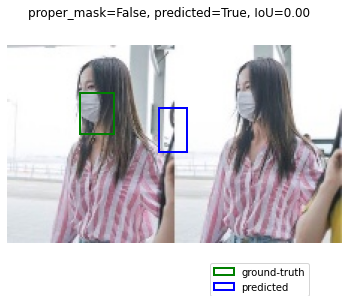

In [21]:
tot_acc = 0
tot_iou = 0
y_true = []
y_pred = []
iou_val_list = []
with torch.no_grad():
  for item in data:
    img = Image.open(os.path.join(image_dir, item[0])).convert('RGB')
    y_bb = torch.FloatTensor(item[2])
    y_class = 1 if item[3] == True else 0
    sizes = torch.FloatTensor([img.width, img.height, img.width, img.height]).unsqueeze(0).to(device)
    img_t = get_input_tensors(img)
    out_class,out_bb = model(img_t.to(device))
    out_bb = torch.mul(out_bb, sizes)
    pred = (out_class > 0.5).int()[0].cpu().detach().numpy()
    iou_val = calc_iou(out_bb[0].cpu().detach().numpy(), y_bb.numpy())
    y_true.append(y_class)
    y_pred.append(pred)
    if y_class == pred:
      accuracy = 1
    else:
      accuracy = 0
    tot_acc += accuracy
    tot_iou += iou_val
    iou_val_list.append(iou_val)
    if iou_val == 0:
      plot_image(item[0],out_bb[0].cpu().detach().numpy(),pred)
      cnt += 1


In [14]:
def calculate_mean_box_size(image_dir,filename, bbox):
  # Load image
  im = cv2.imread(os.path.join(image_dir, filename))
  # BGR to RGB
  im = im[:, :, ::-1]
  h, w, _ = im.shape
  # Ground truth bbox
  x1, y1, w1, h1 = bbox
  precent = (w1*h1) / (h*w)
  return precent

### Finding Bbox size for different IoU values

In [78]:
tot_acc = 0
tot_iou = 0
y_true = []
y_pred = []
iou_val_list = []
iou1, iou2, iou3, iou4, iou5= [], [], [], [], []
iou_fn, iou_fp,iou_tp,iou_tn = [], [], [], []
with torch.no_grad():
  for item in data:
    img = Image.open(os.path.join(image_dir, item[0])).convert('RGB')
    y_bb = torch.FloatTensor(item[2])
    y_class = 1 if item[3] == True else 0
    sizes = torch.FloatTensor([img.width, img.height, img.width, img.height]).unsqueeze(0).to(device)
    img_t = get_input_tensors(img)
    out_class,out_bb = model(img_t.to(device))
    out_bb = torch.mul(out_bb, sizes)
    pred = (out_class > 0.5).int()[0].cpu().detach().numpy()
    iou_val = calc_iou(out_bb[0].cpu().detach().numpy(), y_bb.numpy())
    y_true.append(y_class)
    y_pred.append(pred)
    if y_class == pred:
      accuracy = 1
    else:
      accuracy = 0
    tot_acc += accuracy
    tot_iou += iou_val
    iou_val_list.append(iou_val)
    prec_iou = calculate_mean_box_size('test',item[0],item[2])
    if iou_val < 0.2:
      iou1.append(prec_iou)
    elif iou_val < 0.4:
      iou2.append(prec_iou)
    elif iou_val < 0.6:
      iou3.append(prec_iou)
    elif iou_val < 0.8:
      iou4.append(prec_iou)
    else:
      iou5.append(prec_iou)
      
    if y_class == 1 and pred == 1:
      iou_tp.append(prec_iou)
    elif y_class == 1 and pred == 0:
      iou_fn.append(prec_iou)
    elif y_class == 0 and pred == 0:
      iou_tn.append(prec_iou)
    else:
      iou_fp.append(prec_iou)

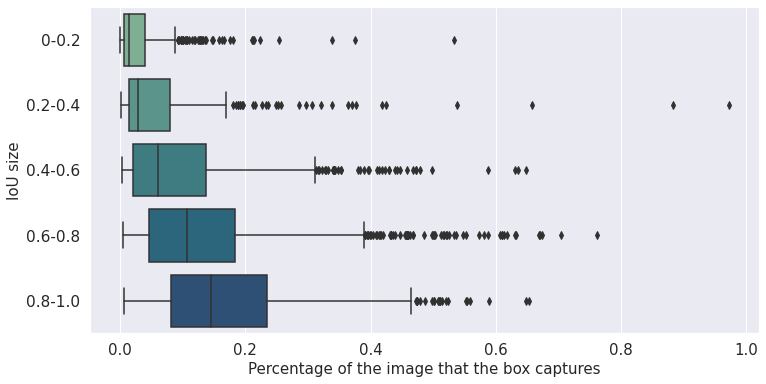

In [55]:
box = iou1+iou2+iou3+iou4+iou5
label = ['0-0.2']*len(iou1) + ['0.2-0.4']*len(iou2) + ['0.4-0.6']*len(iou3) + ['0.6-0.8']*len(iou4) + ['0.8-1.0']*len(iou5)

data = {'Size': box, 'Label': label}
df = pd.DataFrame(data)

fig = plt.figure(figsize=(12,6))
ax = sns.boxplot(x='Size', data=df, y='Label' ,palette='crest')
plt.xlabel("Percentage of the image that the box captures",fontdict={'fontsize':15})
plt.xticks(fontsize=15)
plt.ylabel("IoU size",fontdict={'fontsize':15})
plt.show()

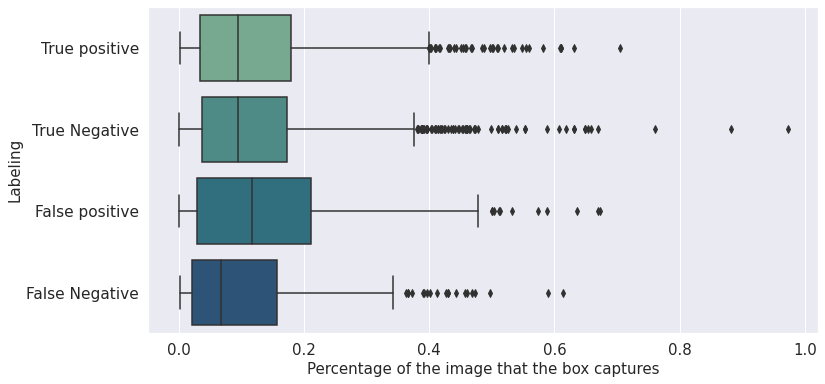

In [81]:
box = iou_tp + iou_tn + iou_fp + iou_fn
label = ['True positive']*len(iou_tp) + ['True Negative']*len(iou_tn) + ['False positive']*len(iou_fp) + ['False Negative']*len(iou_fn) 

data = {'Size': box, 'Label': label}
df = pd.DataFrame(data)

fig = plt.figure(figsize=(12,6))
ax = sns.boxplot(x='Size', data=df, y='Label' ,palette='crest')
plt.xlabel("Percentage of the image that the box captures",fontdict={'fontsize':15})
plt.xticks(fontsize=15)
plt.ylabel("Labeling",fontdict={'fontsize':15})
plt.show()

accuracy: 1524.0 IoU: 1247.4072840543813
Precision: 0.763668430335097 Recall: 0.7025419145484045 F1 score: 0.731830985915493


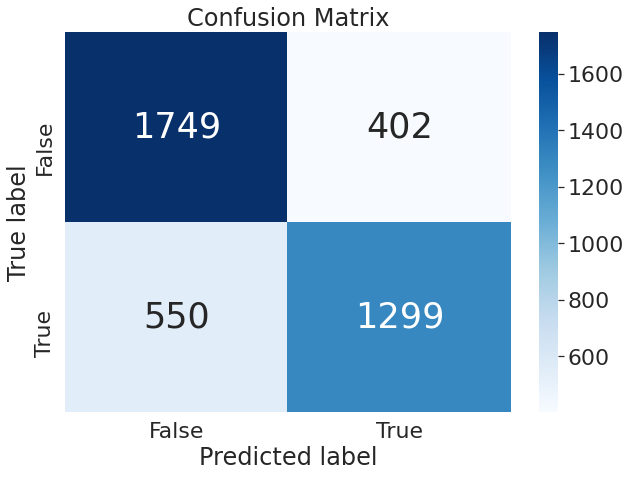

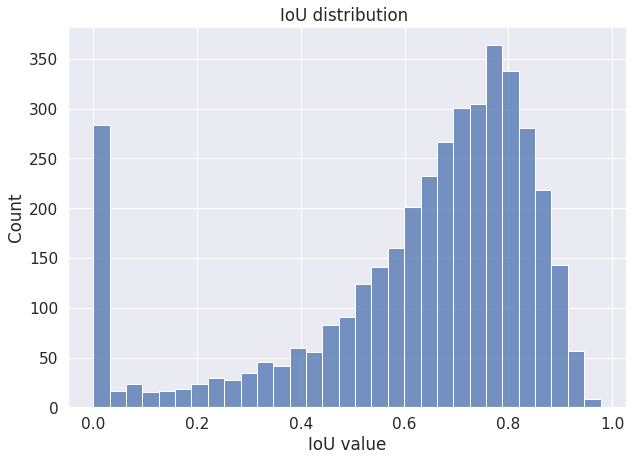

In [85]:
print('accuracy:', tot_acc/len(data),'IoU:',tot_iou/len(data))
from sklearn.metrics import precision_recall_fscore_support
scores = precision_recall_fscore_support(y_true,y_pred, average='binary')
print('Precision:',scores[0],'Recall:',scores[1],'F1 score:', scores[2])
cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize = (10,7))
sns.set(font_scale=2)
sns.heatmap(cm, annot=True,annot_kws={"size": 35},cmap='Blues',xticklabels=['False','True'], yticklabels=['False','True'], fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.histplot(data=iou_val_list)
plt.ylabel('Count')
plt.xlabel('IoU value')
plt.title('IoU distribution ')
plt.show()

##Model interpretability- Lime!

In [ ]:
!pip install lime

In [16]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
explainer = lime_image.LimeImageExplainer()

In [17]:
 def predict(image):
      # image = image.reshape(image.shape[0],image.shape[3],image.shape[1],image.shape[2])
      image = preprocess_transform(image[0]).unsqueeze(0)
      model.eval()
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      model.to(device)
      image = torch.FloatTensor(image)
      image = image.to(device)
      
      probs,_ = model(image)
      probs = probs.cpu().detach().numpy()[0]
      probs = np.array([probs,1-probs])
      # probs = F.softmax(logits, dim=1)
      return [probs]

In [18]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.5244, 0.4904, 0.4781],
                                    std=[0.2655, 0.2623, 0.2576])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()


In [19]:
image_dir = "test"
data = parse_images_and_bboxes(image_dir)


real label: True
predicted: False


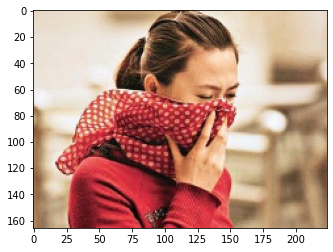

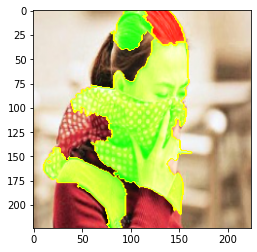


real label: False
predicted: False


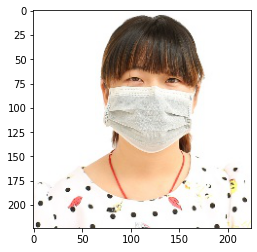

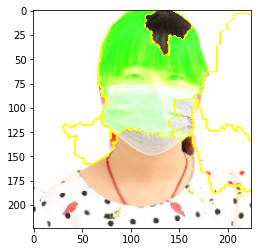


real label: True
predicted: False


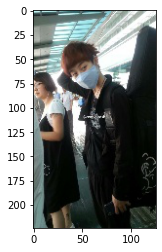

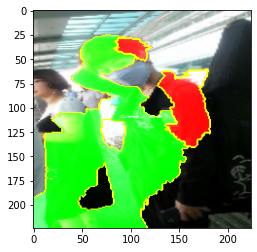

In [20]:
for idx, item in enumerate(data):
  if idx > 2:
    break
  
  img = Image.open(os.path.join(image_dir, item[0])).convert('RGB')
  img_arr = np.array(pill_transf(img))
  image = preprocess_transform(img).unsqueeze(0)
  model.eval()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  image = torch.FloatTensor(image)
  image = image.to(device)
  probs,_ = model(image)

  explanation = explainer.explain_instance(img_arr, predict,
                                         top_labels=1, hide_color=0, num_samples=1000, batch_size=1,)

  print('real label:',item[3])
  if probs < 0.5:
    print('predicted: False')
  else:
    print('predicted: True')
  plt.imshow(img)
  plt.show()
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  img_boundry2 = mark_boundaries(temp/255.0, mask)
  plt.imshow(img_boundry2)
  plt.show()